<table style="border:none; border-collapse:collapse; cellspacing:0; cellpadding:0">
<tr>
    <td width=30% style="border:none">
        <center>
            <img src="../images/iapau_icon.png" width="30%"/><br>
            <a href="https://iapau.org/">Association IA Pau</a><br>
            <a href="https://iapau.org/events/festival/">Festival IAPau 7</a>
        </center>
    </td>
    <td style="border:none">
        <center>
            <h1>Atelier - Agentic RAG</h1>
            <h2>The Mastermind</h2>
            <h2>Orchestration du moteur de raisonnement</h2>
        </center>
    </td>
    <td width=20% style="border:none">
    </td>
</tr>
</table>

---

**Prérequis :** Compléter d'abord les Phases 0, 1 et 2.

Dans ce notebook, nous allons construire le graphe pour orchestrer notre agent IA.

---

## 📋 Table des matières

1. [**Gestion des états**](#define-the-master-graph-and-enhanced-state)
   - `AgentState` TypedDict 
   - Chargement des outils construits dans de la Phase 2

2. [**Nœud `Gatekeeper` : Détection d'ambiguïté**](#gatekeeper-node)
   - Analyse de spécificité des requêtes
   - Génération de questions de clarification

3. [**Nœud `Planner` : Cerveau du superviseur**](#planner-node)
   - Création de plans étape par étape
   - Sélection intelligente des outils

4. [**Nœud `Executor` : Le travailleur**](#tool-executor-node)
   - Exécution des étapes du plan
   - Gestion des résultats intermédiaires

5. [**Nœud `Auditor` : Auto-correction cognitive**](#auditor-node)
   - Vérification de la qualité des sorties
   - Système de scores de confiance

6. [**Routeur conditionnel avancé : Système nerveux**](#routeur)
   - Logique de navigation complexe
   - Gestion des boucles de rétroaction

7. [**Nœud `Strategist` : Synthétiseur avec inférence causale**](#strategist-node)
   - Génération d'insights et connexions
   - Analyse causale des données

8. [**Compilation et exécution du graphe**](#compile-and-run-graph)
   - Assemblage final du moteur de raisonnement
   - Tests et démonstrations

---


In [1]:
import os
import json
from typing import List, Dict, Any, Optional, TypedDict
from rich import print as rprint
from rich.pretty import Pretty
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END
from IPython.display import display, Markdown, HTML

from display_utils import (
    display_available_tools, 
    display_gatekeeper_test, 
    display_planner_test, 
    display_executor_test, 
    display_auditor_test, 
    display_router_test, 
    display_synthesizer_test,
    display_run_app_result
)


<a id="define-the-master-graph-and-enhanced-state"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>1. Gestion des états </div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Nous allons définir la structure de notre agent, c'est-à-dire sont état. La classe <i>AgentState</i> va nous permettre de suivre les différents résultats de notre agents, de la vérification et les questions de clarification potentielles, du suivi du plan et jusqu'au résultat final.</strong></p>
  </div>
</div>

In [2]:
class AgentState(TypedDict):
    """Defines the state of our agent graph."""
    original_request: str
    clarification_question: Optional[str] # For ambiguity handling
    plan: List[str]
    intermediate_steps: List[Dict[str, Any]]
    verification_history: List[Dict[str, Any]] # For self-correction
    final_response: str

print("AgentState TypedDict defined.")

AgentState TypedDict defined.


In [5]:
# Charger les outils de la phase 2
from specialist_tools import librarian_rag_tool, analyst_sql_tool, analyst_trend_tool, tools, tool_map

tools = [librarian_rag_tool, analyst_sql_tool, analyst_trend_tool]
tool_map = {tool.name: tool for tool in tools}

# Display tools in a beautiful formatted way
display_available_tools(tools, tool_map)

✓ Specialist tools loaded successfully!
  Available tools: ['librarian_rag_tool', 'analyst_sql_tool', 'analyst_trend_tool']


<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion de la sortie</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Notre <i>AgentState</i> est maintenant créé, avec des champs dédiés pour <code>clarification_question</code> et <code>verification_history</code>. Cela permettra au graphe de suivre explicitement ces étapes cognitives.</p>
  </div>
</div>

<a id="gatekeeper-node"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>2. `Gatekeeper` Node - Détection d'ambiguïté</div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Il s'agit de notre premier nœud dans le graphe. Avant toute planification, nous allons transmettre la demande de l'utilisateur à un « <i>Gatekeeper</i> ».</p> 
    <p style='margin:0 0 8px 0;color:#000;'>Le rôle du <i>Gatekeeper</i> est de déterminer si la requête est suffisamment spécifique à notre cas d'usage. Si elle est trop vague (par exemple, « Comment va l'entreprise ? »), il générera une question de clarification et arrêtera le processus. Cela empêche l'agent de produire une réponse générique de faible valeur.</strong></p>
  </div>
</div>

In [42]:
ambiguity_llm = ChatOpenAI(model='gpt-4o', api_key=os.environ.get('OPENAI_API_KEY'), temperature=0.)

def ambiguity_check_node(state: AgentState) -> Dict[str, Any]:
    """Checks if the user's request is ambiguous and requires clarification."""
    print("\n-- Gatekeeper (Ambiguity Check) Node --")
    request = state['original_request']
    
    prompt = f"""You are an expert at identifying ambiguity. Given the user's request, is it specific enough to be answered with high precision using financial data and SEC documents?
    - A specific request asks for a number, a date, a named risk, a study, a discuss or a comparison (e.g., 'What was revenue in Q4 2023?').
    - An ambiguous request is very open-ended (e.g., 'How is NVIDIA doing?', 'What's the outlook?').

    If the request is ambiguous, formulate a single, polite question to the user that would provide the necessary clarification. Otherwise, respond with just 'OK'.

    User Request: "{request}"
    
    Response:
    """
    
    response = ambiguity_llm.invoke(prompt).content
    
    if response.strip() == "OK":
        print("  - Request is specific. Proceeding to planner.")
        return {"clarification_question": None}
    else:
        print(f"  - Request is ambiguous. Generating clarification question.")
        return {"clarification_question": response}

In [43]:
# --- Test the Gatekeeper ---

ambiguous_query = "How is NVIDIA doing?"
ambiguous_state = ambiguity_check_node({"original_request": ambiguous_query})

specific_query = "What was the NVIDIA revenue trend over the last 2 years?"
specific_state = ambiguity_check_node({"original_request": specific_query})

# Display formatted results
display_gatekeeper_test(ambiguous_query, ambiguous_state, specific_query, specific_state)


-- Gatekeeper (Ambiguity Check) Node --
  - Request is ambiguous. Generating clarification question.

-- Gatekeeper (Ambiguity Check) Node --
  - Request is specific. Proceeding to planner.



---
### 📊 Résumé des Tests

Le **Gatekeeper** a correctement :
- 🔴 **Identifié** la requête ambiguë et généré une question de clarification appropriée
- 🟢 **Validé** la requête spécifique et autorisé la poursuite du processus

Ce mécanisme de filtrage garantit que l'agent ne travaille que sur des requêtes bien définies et à haute valeur ajoutée.


<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion de la sortie</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Le résultat des tests démontrent l'utilité de la mise en place du <i>Gatekeeper</i>. Il peut identifier correctement la requête vague et génère une question de clarification utile et spécifique. Pour la requête claire, il la laisse passer sans interférence. Ce nœud simple augmente considérablement la précision et l'utilité de l'ensemble du système en s'assurant qu'il ne travaille que sur des problèmes bien définis et à valeur ajouté, une caractéristique clé du comportement humain.</p>
  </div>
</div>

<a id="planner-node"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>3. `Planner` Node</div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Le <i>Planner</i> est notre cerveau. Il prend la requête utilisateur (maintenant vérifiée comme étant spécifique) et, en se basant sur les descriptions des outils disponibles, crée un plan étape par étape pour y répondre.</strong></p>
  </div>
</div>

In [8]:
supervisor_llm = ChatOpenAI(model='gpt-4.1', api_key=os.environ.get('OPENAI_API_KEY'), temperature=0.)

def create_planner_prompt(tools):
    tool_descriptions = "\n".join([f"- {tool.name}: {tool.description.strip()}" for tool in tools])
    
    return f"""You are a master financial analyst agent, the Supervisor. Your task is to create a step-by-step plan to answer the user's request by intelligently selecting from the available tools.
        
        **Available Tools:**
        {tool_descriptions}

        **Instructions:**
        1. Analyze the user's request.
        2. Create a clear, step-by-step plan. Each step must be a call to one of the available tools with a SHORT description in quotes.
        3. The final step in your plan should ALWAYS be 'FINISH'.
        
        **Output Format - CRITICAL:**
        Return ONLY a valid Python list. Do NOT include any explanations, markdown, or code blocks.
        Each tool call must use this exact format: tool_name('short description')
        
        Example (return EXACTLY this format):
        ["analyst_trend_tool('analyze revenue')", "librarian_rag_tool('find risks')", "FINISH"]
        
        User Request: {{request}}
        
        Plan (return ONLY the list):"""

planner_prompt_template = create_planner_prompt(tools)

def planner_node(state: AgentState) -> Dict[str, Any]:
    print("\n-- Planner Node --")
    request = state['original_request']
    prompt = planner_prompt_template.format(request=request)
    plan_str = supervisor_llm.invoke(prompt).content.strip()
    
    # Extract just the list from the response
    # Look for the list pattern [...]
    import re
    
    # Try to find a list pattern in the response
    list_match = re.search(r'\[.*\]', plan_str, re.DOTALL)
    if list_match:
        plan_str = list_match.group(0)
    
    # Remove markdown code blocks if present
    if '```' in plan_str:
        lines = plan_str.split('\n')
        plan_str = '\n'.join([line for line in lines if not line.strip().startswith('```')])
        plan_str = plan_str.strip()
        # Try to extract list again
        list_match = re.search(r'\[.*\]', plan_str, re.DOTALL)
        if list_match:
            plan_str = list_match.group(0)
    
    try:
        # Use ast.literal_eval for safer parsing
        import ast
        plan = ast.literal_eval(plan_str)
        print(f"  - Generated Plan:\n {plan}")
        return {"plan": plan}
    except Exception as e:
        print(f"  - Error parsing plan: {e}")
        print(f"  - Raw plan string: {plan_str}")
        print(f"  - Falling back to FINISH.")
        return {"plan": ["FINISH"]}

In [9]:
# --- Test the Planner Node ---

test_planner_state = {
    "original_request": "Analyze NVIDIA's revenue trend over the last two years and find related competitive risks in the 10-K."}
planner_output = planner_node(test_planner_state)

# Display formatted results
display_planner_test(
    test_planner_state["original_request"],
    planner_output["plan"]
)


-- Planner Node --
  - Generated Plan:
 ["analyst_trend_tool('analyze NVIDIA revenue trend over the last two years')", "librarian_rag_tool('find competitive risks in the latest 10-K')", 'FINISH']



---
### 🔍 Analyse du Plan

Le **Planner** a démontré sa capacité à :
- 🎯 **Décomposer** une requête complexe en étapes logiques et séquentielles
- 🛠️ **Sélectionner** les outils appropriés parmi ceux disponibles (2 outil(s))
- 📋 **Structurer** un plan d'action clair avec une étape finale de terminaison

Cette planification intelligente permet à l'agent d'orchestrer efficacement ses ressources pour répondre aux besoins de l'utilisateur.


<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion des résultats</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Le planificateur exploite correctement notre équipe de spécialistes ! </p>
    <p style='margin:0 0 8px 0;color:#000;'>Pour une requête nécessitant à la fois une analyse de tendances et une récupération de documents, il crée un plan parfait. Il sait utiliser l'<code>analyst_trend_tool</code> spécialisé pour l'analyse de séries temporelles et le <code>librarian_rag_tool</code> pour les informations qualitatives sur les risques.</p> 
    <p style='margin:0 0 8px 0;color:#000;'>Cela démontre que les descriptions claires des outils permettent au <i>Planner</i> de déléguer les tâches correctement.</p>
  </div>
</div>

<a id="tool-executor-node"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>4. `Tool Executor` Node</div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Ce nœud est le travailleur du système (i.e. <i>Executor</i>). Il prend le plan, exécute la prochaine étape en utilisant l'outil approprié, et ajoute le résultat à <code>intermediate_steps</code>.</strong></p>
  </div>
</div>

In [10]:
def tool_executor_node(state: AgentState) -> Dict[str, Any]:
    print("\n-- Tool Executor Node --")
    next_step = state['plan'][0]
    try:
        tool_name = next_step.split('(')[0]
        tool_input_str = next_step[len(tool_name)+1:-1]
        tool_input = eval(tool_input_str)
    except Exception as e:
        print(f"  - Error parsing tool call: {e}. Skipping step.")
        return {"plan": state['plan'][1:], "intermediate_steps": state.get('intermediate_steps', [])}

    print(f"  - Executing tool: {tool_name} with input: '{tool_input}'")
    tool_to_call = tool_map[tool_name]
    result = tool_to_call.invoke(tool_input)
    
    new_intermediate_step = {
        'tool_name': tool_name,
        'tool_input': tool_input,
        'tool_output': result
    }
    
    current_steps = state.get('intermediate_steps', [])
    return {
        "intermediate_steps": current_steps + [new_intermediate_step],
        "plan": state['plan'][1:]
    }

In [11]:
# --- Test the Executor Node ---

test_executor_state = {
    'plan': ["analyst_trend_tool('Analyze revenue trend')", "FINISH"],
    'intermediate_steps': []
}
executor_output = tool_executor_node(test_executor_state)

# Display formatted results
display_executor_test(
    plan=test_executor_state['plan'],
    remaining_plan=executor_output['plan'],
    intermediate_steps=executor_output['intermediate_steps']
)


-- Tool Executor Node --
  - Executing tool: analyst_trend_tool with input: 'Analyze revenue trend'

-- Analyst Trend Tool Called with query: 'Analyze revenue trend' --



---
### 🔍 Analyse de l'Exécution

Le **Tool Executor** a démontré sa capacité à :
- ⚙️ **Exécuter** l'outil sélectionné avec succès (analyst_trend_tool)
- 📦 **Capturer** la sortie de l'outil dans l'état intermédiaire
- 🔄 **Mettre à jour** le plan en retirant l'étape exécutée
- 📊 **Préparer** le système pour la prochaine étape du processus

L'exécuteur agit comme le travailleur du système, transformant les instructions du planificateur en actions concrètes et en gérant l'état de l'agent de manière structurée.


<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion des résultats</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Le test démontre que notre <code>analyst_trend_tool</code> peut être appelé comme n'importe quel autre outil. L'exécuteur a lancé l'outil avec succès, capturé sa sortie narrative et l'a ajoutée à l'état. Le plan a été mis à jour correctement, montrant que le système est prêt pour la prochaine étape de son processus de raisonnement.</p>
  </div>
</div>

<a id="auditor-node"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>5. `Auditor` Node - Auto-correction cognitive</div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Après l'exécution d'un outil, sa sortie est transmise à ce nœud <i>Auditor</i>. L'<i>Auditor</i> agit comme un <strong>second avis</strong> critique. Il évalue la sortie de l'outil par rapport à la demande originale pour vérifier la pertinence et la cohérence. Si la sortie est de faible qualité, le système peut être redirigé vers le <i>Planner</i> pour essayer une approche différente. Cela construit une couche d'<strong>auto-correction</strong> dans la boucle de raisonnement de l'agent.</strong></p>
    <p style='margin:0 0 8px 0;color:#000;'>Il s'agit d'une amélioration cognitive majeure. </p>
  </div>
</div>

In [12]:
class VerificationResult(BaseModel):
    """Structured output for the Auditor node."""
    confidence_score: int = Field(description="Score from 1-5 on confidence in the tool's output.")
    is_consistent: bool = Field(description="Is the output internally consistent?")
    is_relevant: bool = Field(description="Is the output relevant to the original user request?")
    reasoning: str = Field(description="Brief reasoning for the scores.")

auditor_llm = ChatOpenAI(model='gpt-4o', api_key=os.environ.get('OPENAI_API_KEY'), temperature=0.).with_structured_output(VerificationResult)

def verification_node(state: AgentState) -> Dict[str, Any]:
    """Audits the most recent tool output for quality and relevance."""
    print("\n-- Auditor (Self-Correction) Node --")
    request = state['original_request']
    last_step = state['intermediate_steps'][-1]
    
    prompt = f"""You are a meticulous fact-checker and auditor. Given the user's original request and the output from a tool, please audit the output.
    
    **User Request:** {request}
    **Tool:** {last_step['tool_name']}
    **Tool Output:** {json.dumps(last_step['tool_output'])}
    
    **Audit Checklist:**
    1.  **Relevance:** Is this output directly relevant to answering the user's request? (Score 1-5, where 5 is highly relevant).
    2.  **Consistency:** Is the data internally consistent? (e.g., no contradictory statements).
    
    Based on this, provide a confidence score and a brief reasoning.
    """
    
    audit_result = auditor_llm.invoke(prompt)
    print(f"  - Audit Confidence Score: {audit_result.confidence_score}/5")
    
    current_history = state.get('verification_history', [])
    # Il suffit de renvoyer l'historique de vérification, le routeur se chargera du reste.
    return {"verification_history": current_history + [audit_result.model_dump()]}

In [13]:
# --- Test Auditor ---

test_auditor_state = {
    'original_request': 'Analyze the revenue trend over the last two years',
    'intermediate_steps': executor_output['intermediate_steps']
}
auditor_output = verification_node(test_auditor_state)

# Display formatted results
display_auditor_test(
    original_request=test_auditor_state['original_request'],
    verification_result=auditor_output['verification_history'][0]
)


-- Auditor (Self-Correction) Node --
  - Audit Confidence Score: 3/5



---
### 🔍 Analyse de la Vérification

Le **Auditor** a démontré sa capacité à :
- 🎯 **Évaluer** la pertinence de la sortie par rapport à la requête originale
- 🔍 **Vérifier** la cohérence interne des données retournées
- 📊 **Attribuer** un score de confiance quantitatif (3/5)
- 💭 **Justifier** sa décision avec un raisonnement clair

Cette couche d'auto-correction cognitive permet au système de détecter les sorties de faible qualité et de déclencher une replanification si nécessaire, rendant l'agent plus robuste et fiable.


<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion des résultats</h2>
    <p style='margin:0 0 8px 0;color:#000;'>L'<i>Auditor</i> a évalué avec succès la sortie de l'outil <code>analyst_trend_tool</code>. Il a attribué un score de confiance et confirmé que l'information est à la fois cohérente et pertinente. Cette étape de vérification structurée est cruciale pour construire la confiance. Si un outil devait retourner des données incohérentes, ce nœud le signalerait avec un score de confiance faible, permettant à notre routeur (dans l'étape suivante) de prendre des mesures correctives, comme replanifier la tâche. Cela rend l'ensemble du système plus robuste et fiable.</p>
  </div>
</div>

<a id="routeur"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>6. Routeur conditionnel</div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Nous avons maintenant besoin d'un routeur conditionnel qui peut gérer le flux de notre moteur de raisonnement. Ce routeur inspectera l'état après chaque étape et décidera où aller ensuite basé sur une hiérarchie de conditions :</p>
    <p style='margin:0 8px 0 0;font-weight:600;color:#000;'></p>
    <ul style='margin:8px 0 0 18px;color:#000;'>
      <li><strong>Une question de clarification a-t-elle été générée ?</strong>  (Ceci est vérifié au début). Si oui, s'arrêter et demander à l'utilisateur.</li>
      <li><strong>La dernière vérification a-t-elle échoué</strong>  (ex., score de confiance < 3) ? Si oui, revenir au Planificateur pour essayer une nouvelle approche.</li>
      <li><strong>Le plan est-il terminé ?</strong>  Si oui, procéder au Synthétiseur (i.e. <i>Strategist</i>).</li>
      <li><strong>Sinon</strong> , revenir à l'exécuteur d'outils (i.e. <i>Executor</i>) pour continuer le plan.</li>
    </ul>
  </div>
</div>

In [14]:
def router_node(state: AgentState, min_score: int=3) -> str:
    """This node decides the next step in the graph based on the current state."""
    print("\n-- Advanced Router Node --")

    # Check for clarification first, this is a terminal state
    if state.get("clarification_question"):
        print("  - Decision: Ambiguity detected. Halting to ask user.")
        return END

    # Check if we need to start the main workflow
    if not state.get("plan"):
        print("  - Decision: New request. Routing to planner.")
        return "planner"

    # Check the last verification result if it exists
    if state.get("verification_history"):
        last_verification = state["verification_history"][-1]
        if last_verification["confidence_score"] < min_score:
            print("  - Decision: Verification failed. Returning to planner.")
            # Clear the plan to force replanning
            state['plan'] = [] 
            return "planner"

    # Check if the plan is complete
    if not state.get("plan") or state["plan"][0] == "FINISH":
        print("  - Decision: Plan is complete. Routing to synthesizer.")
        return "synthesize"
    else:
        print("  - Decision: Plan has more steps. Routing to tool executor.")
        return "execute_tool"

In [15]:
# --- Test the Router Logic ---

# Define test cases
test_cases = [
    {
        'name': 'Cas de Test 1 : Ambiguïté Détectée',
        'icon': '⚠️',
        'color_class': 'case-ambiguity',
        'state': {'clarification_question': 'Please clarify.'},
        'result': router_node({'clarification_question': 'Please clarify.'}),
        'explanation': "Lorsqu'une question de clarification existe, le routeur termine immédiatement l'exécution pour demander des précisions à l'utilisateur. C'est un état terminal qui empêche le traitement d'une requête ambiguë."
    },
    {
        'name': 'Cas de Test 2 : Échec de Vérification',
        'icon': '🔄',
        'color_class': 'case-verification',
        'state': {'verification_history': [{'confidence_score': 2}], 'plan': []},
        'result': router_node({'verification_history': [{'confidence_score': 2}], 'plan': []}),
        'explanation': "Avec un score de confiance faible (< 3), le routeur détecte une sortie de qualité insuffisante et redirige vers le planificateur pour essayer une nouvelle approche. C'est la boucle d'auto-correction en action."
    },
    {
        'name': 'Cas de Test 3 : Plan en Cours',
        'icon': '⚙️',
        'color_class': 'case-continue',
        'state': {'plan': ['step 1', 'FINISH'], 'verification_history': [{'confidence_score': 5}]},
        'result': router_node({'plan': ['step 1', 'FINISH'], 'verification_history': [{'confidence_score': 5}]}),
        'explanation': "Le plan contient encore des étapes à exécuter et la vérification a réussi (score = 5). Le routeur dirige vers l'exécuteur d'outils pour continuer l'exécution séquentielle du plan."
    },
    {
        'name': 'Cas de Test 4 : Plan Terminé',
        'icon': '🎯',
        'color_class': 'case-finish',
        'state': {'plan': ['FINISH'], 'verification_history': [{'confidence_score': 5}]},
        'result': router_node({'plan': ['FINISH'], 'verification_history': [{'confidence_score': 5}]}),
        'explanation': "Le plan n'a plus que l'étape FINISH et la vérification a réussi. Le routeur dirige vers le synthétiseur pour générer la réponse finale consolidée avec inférence causale."
    }
]

# Display formatted results
display_router_test(test_cases)


-- Advanced Router Node --
  - Decision: Ambiguity detected. Halting to ask user.

-- Advanced Router Node --
  - Decision: New request. Routing to planner.

-- Advanced Router Node --
  - Decision: Plan has more steps. Routing to tool executor.

-- Advanced Router Node --
  - Decision: Plan is complete. Routing to synthesizer.



---
### 🔍 Analyse du Routeur

Le **Router** est le système nerveux de notre agent. Il a démontré sa capacité à :
- 🧠 **Analyser** l'état courant du système de manière hiérarchique
- 🔀 **Décider** du prochain nœud à exécuter selon une logique conditionnelle sophistiquée
- 🔄 **Gérer** les boucles de rétroaction pour l'auto-correction
- 🎯 **Optimiser** le flux d'exécution pour maximiser la qualité des résultats

Cette logique de routage complexe transforme notre graphe linéaire en un véritable moteur de raisonnement cognitif capable d'adaptation et d'auto-amélioration.


<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion des résultats</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Les cas de test confirment la logique de notre routeur. Il gère correctement tous les états clés de notre moteur de raisonnement : s'arrêter pour demander des clarifications à l'utilisateur, revenir au planificateur en cas d'échec de vérification, continuer le plan quand tout se passe bien, et finalement passer à la synthèse lorsque le travail est terminé. </p>
    <p style='margin:0 0 8px 0;color:#000;'>Ce routeur est le <strong>système nerveux</strong> de notre agent.</p>
  </div>
</div>

<a id="strategist-node"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>7. `Strategist` Node - Synthétiseur avec inférence causale</div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Il s'agit de la note finale de notre agent. Le Synthétiseur (i.e. <i>Strategist</i>) ne se contentera pas de résumer les données collectées. Nous définissons son prompt pour l'instruire d'agir comme un stratège: il doit essayer de <strong>faire le lien</strong> entre les différentes informations recueillies par les outils. S'il voit une tendance financière de l'<i>Analyst</i> et un risque lié du <i>Librerian</i>, il devrait générer une hypothèse sur un lien causal potentiel. Cela fait passer l'agent du rapport de faits à la génération de perspectives (avec perspicacité).</p>
  </div>
</div>

In [16]:
synthesizer_llm = ChatOpenAI(model='gpt-4o', api_key=os.getenv('OPENAI_API_KEY'), temperature=0.2)

def synthesizer_node(state: AgentState) -> Dict[str, Any]:
    print("\n-- Strategist (Synthesizer) Node --")
    request = state['original_request']
    context = "\n\n".join([f"## Tool: {step['tool_name']}\nInput: {step['tool_input']}\nOutput: {json.dumps(step['tool_output'], indent=2)}" for step in state['intermediate_steps']])

    prompt = f"""You are an expert financial analyst acting as a strategist. Your task is to synthesize a comprehensive answer 
    to the user's request based on the context provided by your specialist agents, generating novel insights where possible.

    **User Request:**
    {request}

    **Context from Agents:**
    ---
    {context}
    ---

    **Instructions:**
    1.  Carefully review the context from the tool outputs.
    2.  Construct a clear, well-written, and accurate answer to the user's original request.
    3.  **Connect the Dots (Causal Inference):** After summarizing the findings, analyze the combined information. Is there a plausible causal link or correlation between different pieces of data (e.g., a risk mentioned by the Librarian and a financial trend from the Analyst)?
    4.  **Frame as Hypothesis:** Clearly state this connection as a data-grounded hypothesis, using phrases like 'The data suggests a possible link...' or 'One potential hypothesis is...'. This is your key value-add.

    Final Answer:
    """
    
    final_answer = synthesizer_llm.invoke(prompt).content
    print("  - Generated final answer with causal inference.")
    return {"final_response": final_answer}

In [17]:
# --- Test the Synthesizer Node ---
# Use the executor output from the previous test
test_synth_state = {
    'original_request': "Analyze the revenue trend from 2022 to 2024 and connect it to any major AI-related risks.",
    'intermediate_steps': [
        executor_output['intermediate_steps'][0],  # Use the trend tool output from executor test
        {'tool_name': 'librarian_rag_tool', 'tool_input': 'AI risks', 'tool_output': [
            {'source': '10-K/0001045810-25-000023', 'content': 'Competition in the AI field is rapidly evolving...',
             'summary': 'This section highlights the intensifying competition in the rapidly evolving field of Artificial Intelligence (AI) as a key risk.'}
        ]}
    ]
}
synth_output = synthesizer_node(test_synth_state)

# Display formatted results
display_synthesizer_test(
    original_request=test_synth_state['original_request'],
    intermediate_steps=test_synth_state['intermediate_steps'],
    final_response=synth_output['final_response']
)


-- Strategist (Synthesizer) Node --
  - Generated final answer with causal inference.


Based on the analysis of the revenue trend from 2022 to 2024, there is a clear upward trajectory in revenue, starting at $3.11 billion and reaching $35.08 billion by the end of 2024. The most recent quarter (2024-Q4) showed a significant Quarter-over-Quarter growth of 16.8% and an impressive Year-over-Year growth of 93.6%. This indicates consistent and robust growth over the analyzed period.

In parallel, the context provided by the librarian highlights a major AI-related risk: the intensifying competition in the rapidly evolving field of Artificial Intelligence (AI). This competition is a key risk factor for companies operating in this space.

**Connecting the Dots (Causal Inference):** The data suggests a possible link between the rapid revenue growth and the competitive landscape in AI. One potential hypothesis is that the significant revenue growth from 2022 to 2024 could be driven by the company's strategic investments and innovations in AI, which have allowed it to capture a larger market share. However, this growth is not without risks. The intensifying competition in AI could pose a threat to sustaining this growth trajectory. Companies may need to continuously innovate and adapt to maintain their competitive edge, which could impact future revenue stability.

In summary, while the revenue trend is positive, the evolving competitive dynamics in AI present a risk that could influence future financial performance. This underscores the importance of strategic planning and innovation in navigating the AI landscape.


---
### 🔍 Analyse de la Synthèse

Le **Strategist** a démontré sa capacité à :
- 📊 **Compiler** les résultats de 2 outil(s) spécialisé(s) de manière cohérente
- 🔗 **Connecter** les informations provenant de sources différentes (données quantitatives et qualitatives)
- 💭 **Générer** des hypothèses causales et des insights au-delà de la simple compilation
- 📝 **Articuler** une réponse claire, structurée et à haute valeur ajoutée

Cette capacité d'**inférence causale** transforme notre agent d'un simple agrégateur de données en un véritable **moteur de raisonnement** capable de générer des perspectives analytiques comparables à celles d'un expert humain.


<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion des résultats</h2>
    <p style='margin:0 0 8px 0;color:#000;'>L'agent ne se contente pas de lister la tendance des revenus et le risque lié à l'IA côte à côte. Il les connecte activement, formant une hypothèse raisonnable et fondée sur les données: que la chose même qui stimule la croissance (l'investissement dans l'IA) est également une source majeure de risque. C'est une forme d'insight qui imite la pensée critique d'un analyste humain. La capacité à générer de telles connexions est ce qui élève véritablement l'agent d'un simple outil à un moteur de raisonnement.</p>
  </div>
</div>

<a id="compile-and-run-graph"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>8. Compilation et exécution du graphe</div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Il est temps d'assembler tous nos nœuds dans le graphe de raisonnement complet. Le flux est maintenant finalisé, intégrant le <i>Gatekeeper</i>, l'<i>Executor</i>, l'<i>Auditor</i>, le <i>Strategist</i> et plusieurs boucles de rétroaction.</p>
  </div>
</div>

Graph compiled successfully!


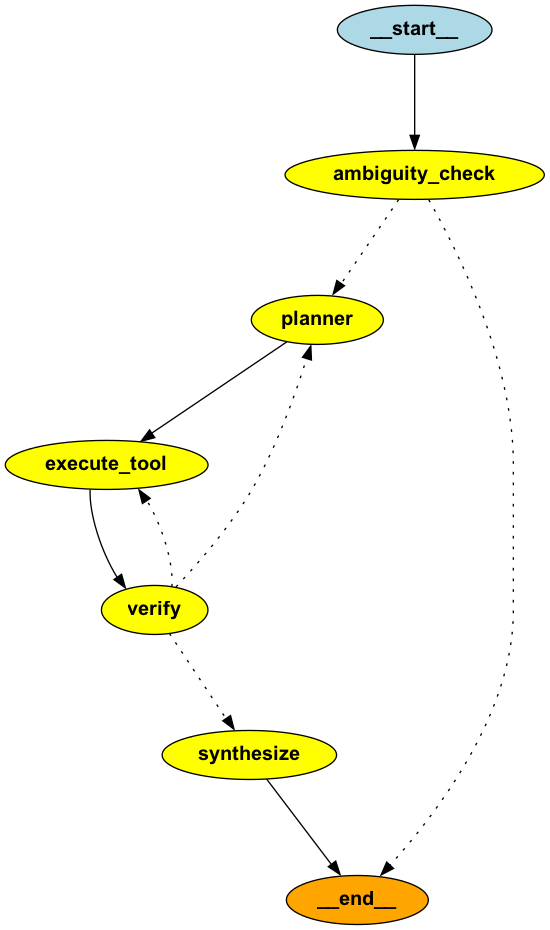

In [44]:
graph_builder = StateGraph(AgentState)

# Ajouter des nœuds au graphe
graph_builder.add_node("ambiguity_check", ambiguity_check_node)
graph_builder.add_node("planner", planner_node)
graph_builder.add_node("execute_tool", tool_executor_node)
graph_builder.add_node("verify", verification_node)
graph_builder.add_node("synthesize", synthesizer_node)

# Définir le point d'entrée
graph_builder.set_entry_point("ambiguity_check")

# Définir la connexion conditionnelle à partir du vérificateur d'ambiguïté
graph_builder.add_conditional_edges(
    "ambiguity_check",
    lambda state: "planner" if state.get("clarification_question") is None else END,
    {"planner": "planner", END: END}
)

# Après la planification, exécutez toujours un outil.
graph_builder.add_edge("planner", "execute_tool")

# Après l'exécution, vérifiez toujours
graph_builder.add_edge("execute_tool", "verify")

# Le ROUTEUR CONDITIONNEL relie l'étape de vérification au nœud logique suivant.
graph_builder.add_conditional_edges(
    "verify",
    router_node,
    {
        "planner": "planner",
        "execute_tool": "execute_tool",
        "synthesize": "synthesize",
    }
)

# Le synthétiseur est un nœud terminal
graph_builder.add_edge("synthesize", END)

# Compiler le graphique
app = graph_builder.compile()

print("Graph compiled successfully!")
try:
    from IPython.display import Image, display
    # Créer et afficher le graphique
    png_image = app.get_graph().draw_png()
    display(Image(png_image))
except Exception as e:
    print(f"Could not visualize graph: {e}")


<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion des résultats</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Le graphe est maintenant compilé et prêt à être utilisé.</p> 
    <p style='margin:0 0 8px 0;color:#000;'>La visualisation montre notre boucle de raisonnement. Vous pouvez suivre le chemin depuis la vérification d'ambiguïté initiale, en passant par le planificateur, jusqu'à la boucle principale <strong>execute_tool -> verify -> router</strong>.</p> 
    <p style='margin:0 0 8px 0;color:#000;'>Les arêtes conditionnelles du routeur montrent la boucle de rétroaction vers le planificateur (pour l'auto-correction) ou l'exécuteur (pour continuer le plan), ainsi que le chemin final vers le synthétiseur. Cette carte visuelle rend la logique de notre agent claire et compréhensible.</p>
  </div>
</div>

In [45]:
def run_app(query: str):
    """Un wrapper pour exécuter le graphe et imprimer le résultat final de manière claire."""
    print("\n" + "="*40)
    print("🚀 RUNNING APP")
    print("="*40)
    print(f"📝 Query: {query}")
    print("="*40 + "\n")
    
    # Ensure initial state has empty lists for accumulation
    inputs = {"original_request": query, "verification_history": [], "intermediate_steps": []}
    final_state = {}
    
    # Use a for loop to stream and see the flow, but capture the last state for the final answer
    for output in app.stream(inputs, stream_mode="values"):
        final_state.update(output)
    
    print("\n" + "="*40)
    if final_state.get('clarification_question'):
        print("❓ CLARIFICATION NEEDED")
        print("="*40)
        display(Markdown(final_state['clarification_question']))
    else:
        print("✅ FINAL SYNTHESIZED RESPONSE")
        print("="*40 + "\n")
        display(Markdown(final_state['final_response']))
    
    return final_state


In [20]:
# Exécuter avec une requête ambiguë
test_label = "TEST 1: AMBIGUOUS QUERY"
query = "Tell me about Nvidia's performance."

print("\n" + "="*40)
print(f"🚀 RUNNING: {test_label}")
print("="*40 + "\n")

# Ensure initial state has empty lists for accumulation
inputs = {"original_request": query, "verification_history": [], "intermediate_steps": []}
final_state = {}

# Use a for loop to stream and see the flow, but capture the last state for the final answer
for output in app.stream(inputs, stream_mode="values"):
    final_state.update(output)

# Display formatted result
display_run_app_result(test_label, query, final_state, test_type="ambiguous")



🚀 RUNNING: TEST 1: AMBIGUOUS QUERY


-- Gatekeeper (Ambiguity Check) Node --
  - Request is ambiguous. Generating clarification question.


In [21]:
# Exécutez une requête complexe et spécifique.
test_label = "TEST 2: COMPLEX SPECIFIC QUERY"
query = "Analyze Nvidia's revenue trend from 2022 to 2024 by Quarter."

print("\n" + "="*40)
print(f"🚀 RUNNING: {test_label}")
print("="*40 + "\n")

# Ensure initial state has empty lists for accumulation
inputs = {"original_request": query, "verification_history": [], "intermediate_steps": []}
final_state = {}

# Use a for loop to stream and see the flow, but capture the last state for the final answer
for output in app.stream(inputs, stream_mode="values"):
    final_state.update(output)

# Display formatted result
display_run_app_result(test_label, query, final_state, test_type="specific")



🚀 RUNNING: TEST 2: COMPLEX SPECIFIC QUERY


-- Gatekeeper (Ambiguity Check) Node --
  - Request is specific. Proceeding to planner.

-- Planner Node --
  - Generated Plan:
 ["analyst_trend_tool('analyze Nvidia revenue trend by quarter from 2022 to 2024')", 'FINISH']

-- Tool Executor Node --
  - Executing tool: analyst_trend_tool with input: 'analyze Nvidia revenue trend by quarter from 2022 to 2024'

-- Analyst Trend Tool Called with query: 'analyze Nvidia revenue trend by quarter from 2022 to 2024' --

-- Auditor (Self-Correction) Node --
  - Audit Confidence Score: 4/5

-- Advanced Router Node --
  - Decision: Plan is complete. Routing to synthesizer.

-- Strategist (Synthesizer) Node --
  - Generated final answer with causal inference.


Based on the analysis of Nvidia's revenue trend from 2022 to 2024 by quarter, the data indicates a robust upward trajectory in the company's financial performance. Starting from a revenue of $3.11 billion in early 2020, Nvidia's revenue has consistently increased, reaching $35.08 billion by the fourth quarter of 2024. The most recent quarter, 2024-Q4, experienced a significant quarter-over-quarter growth of 16.8% and an impressive year-over-year growth of 93.6%.

This consistent growth over the analyzed period suggests that Nvidia has been effectively capitalizing on its market opportunities, likely driven by strong demand for its products in sectors such as gaming, data centers, and artificial intelligence. The substantial year-over-year growth in the most recent quarter further underscores the company's ability to scale its operations and capture market share.

**Causal Inference and Hypothesis:**

The data suggests a possible link between Nvidia's revenue growth and the increasing global demand for advanced computing solutions, particularly in AI and data processing. One potential hypothesis is that Nvidia's strategic investments in cutting-edge technology and its expansion into new markets have been key drivers of its revenue growth. Additionally, the company's ability to innovate and adapt to changing market dynamics may have contributed to its sustained financial performance. This hypothesis could be further explored by examining Nvidia's product launches, market expansion strategies, and competitive positioning during this period.

In [55]:
# Exécutez une requête complexe et spécifique.
test_label = "TEST 3: COMPLEX MULTI-SOURCE QUERY"
#query = "Analyze Nvidia's revenue trend from 2020 to 2024 and discuss the CEO risk strategy mentioned in their reports."
query = "Analyze Nvidia's revenue trend from 2020 to 2024 and discuss the risk strategy, mentioned in their reports, to increase these revenues."

print("\n" + "="*40)
print(f"🚀 RUNNING: {test_label}")
print("="*40 + "\n")

# Ensure initial state has empty lists for accumulation
inputs = {"original_request": query, "verification_history": [], "intermediate_steps": []}
final_state = {}

# Use a for loop to stream and see the flow, but capture the last state for the final answer
for output in app.stream(inputs, stream_mode="values"):
    final_state.update(output)

# Display formatted result
display_run_app_result(test_label, query, final_state, test_type="specific")



🚀 RUNNING: TEST 3: COMPLEX MULTI-SOURCE QUERY


-- Gatekeeper (Ambiguity Check) Node --
  - Request is specific. Proceeding to planner.

-- Planner Node --
  - Generated Plan:
 ["analyst_trend_tool('analyze Nvidia revenue trend from 2020 to 2024')", "librarian_rag_tool('find risk strategy in Nvidia reports related to increasing revenues')", 'FINISH']

-- Tool Executor Node --
  - Executing tool: analyst_trend_tool with input: 'analyze Nvidia revenue trend from 2020 to 2024'

-- Analyst Trend Tool Called with query: 'analyze Nvidia revenue trend from 2020 to 2024' --

-- Auditor (Self-Correction) Node --
  - Audit Confidence Score: 4/5

-- Advanced Router Node --
  - Decision: Plan has more steps. Routing to tool executor.

-- Tool Executor Node --
  - Executing tool: librarian_rag_tool with input: 'find risk strategy in Nvidia reports related to increasing revenues'

-- Librarian Tool Called with query: 'find risk strategy in Nvidia reports related to increasing revenues' --
  - Optim

Nvidia's revenue trend from 2020 to 2024 shows a significant upward trajectory. Starting at $3.11 billion in early 2020, the company's revenue reached $35.08 billion by the end of 2024. The most recent quarter (2024-Q4) demonstrated a robust quarter-over-quarter growth of 16.8% and an impressive year-over-year growth of 93.6%. This consistent growth over the analyzed period reflects Nvidia's successful expansion and adaptation in various computationally intensive fields.

In terms of risk strategy to increase revenues, Nvidia's reports highlight several key areas:

1. **Expansion into New Markets:** Nvidia has leveraged its GPU architecture beyond PC graphics into fields such as scientific computing, AI, data science, autonomous vehicles, robotics, and digital twin applications. This diversification helps mitigate risks associated with reliance on a single market segment.

2. **Focus on Data Center and AI Solutions:** Recent revenue growth has been driven by data center compute and networking platforms for accelerated computing and AI solutions. The introduction and ramp-up of their Blackwell architectures have been pivotal in this growth, indicating a strategic focus on high-demand, high-growth areas.

3. **Investment and Acquisition Strategy:** Nvidia invests in and acquires businesses that align with its strategic objectives, aiming to expand or enhance its product offerings. However, this strategy also involves risks related to integration challenges and the realization of potential benefits.

4. **Supply Chain Management:** Nvidia faces risks related to long manufacturing lead times and uncertain supply and component availability. Accurate demand estimation is crucial to avoid mismatches between supply and demand, which have previously led to product shortages and excess inventory.

**Causal Inference and Hypothesis:**

The data suggests a possible link between Nvidia's strategic focus on expanding into high-growth areas like AI and data centers and its impressive revenue growth. One potential hypothesis is that Nvidia's ability to adapt its core GPU technology to meet the demands of emerging markets has been a key driver of its revenue increase. Additionally, while the expansion into new markets and strategic acquisitions have contributed to growth, they also introduce risks related to integration and supply chain management. Successfully navigating these risks is crucial for sustaining the upward revenue trend.

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion de la sortie</h2>
    <p style='margin:0 0 8px 0;color:#000;'>C'est l'aboutissement de notre agent. La sortie démontre toute la puissance de ces capacités de raisonnement.</p>
    <p style='margin:0 8px 0 0;font-weight:600;color:#000;'></p>
    <ul style='margin:8px 0 0 18px;color:#000;'>
      <li><strong>Gestion de l'ambiguïté</strong> : La première exécution montre le `Gatekeeper` en action. Face à une requête vague, l'agent s'arrête correctement et demande des précisions, économisant du calcul et offrant une meilleure expérience utilisateur.</li><br>
      <li><strong>Boucle cognitive</strong> : La deuxième exécution met en valeur toute la boucle cognitive. Nous voyons le `Gatekeeper` approuver la requête, le Planificateur créer un plan en plusieurs étapes utilisant le nouvel `analyst_trend_tool`, l'Exécuteur et l'Auditeur travailler en tandem pour chaque étape, et le Routeur guider correctement le flux.</li><br>
      <li><strong>Synthèse perspicace</strong> : La réponse finale est la partie la plus impressionnante. Elle ne se contente pas d'énumérer des faits. Elle synthétise l'analyse de tendance et les informations sur les risques en une hypothèse cohérente et perspicace. Le type d'analyse à valeur ajoutée que vous attendriez d'un analyste humain qualifié. Cette exécution réussie valide toute notre architecture.</li>
    </ul>
    <br>
    <p style='margin:0 0 8px 0;color:#000;'>Cooment évaluer notre Agent IA ?</p>
  </div>
</div>